In [1]:
import numpy as np
import pandas as pd

from utils import validate, package_run_data, package_calib_data, circdist, circmedian
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

from cmdstanpy import CmdStanModel

#NP set random seed
np.random.seed(42)

az.style.use("arviz-docgrid")

In [2]:
experiment_orientations = [159, 123, 87, 51, 15]
subjects = ["01", "02", "03", "04", "05", "06", "07", "08" ,"09", "10", "11", "12", "14"]
median_key = {15:0, 51:1, 87:2, 123:3, 159:4}
std_key = {15:0, 51:1, 87:2, 123:3, 159:4}

In [3]:
# Allow negative angles
c_table, med, std, ctimetable = package_calib_data(do_clip=False)
r_table, (x, y, d, r, e) = package_run_data(med, std, do_clip=False)

Loading data:   0%|          | 0/52 [00:00<?, ?it/s]

Loading data: 100%|██████████| 312/312 [00:01<00:00, 289.27it/s]


## Splitting the data for stan

In [4]:
xaxis = np.arange(-250, 750, 1) * (1000/120)

In [5]:
start_idx, end_idx = np.searchsorted(xaxis, -500), np.searchsorted(xaxis, 1500)
(start_idx, end_idx)

(191, 430)

In [6]:
low_coherence_mask = r_table["coh"] == -1
high_coherence_mask = r_table["coh"] == 1

divided_attention_mask = r_table["att"] == -1
focused_attention_mask = r_table["att"] == 1

unexpected_mask = r_table["exp_al"] == 0
expected_mask = r_table["exp_al"] == 1

In [7]:
r_low = r.reshape(-1, 1000)[low_coherence_mask]
r_high = r.reshape(-1, 1000)[high_coherence_mask]

r_divided = r.reshape(-1, 1000)[divided_attention_mask]
r_focused = r.reshape(-1, 1000)[focused_attention_mask]

r_unexpected = r.reshape(-1, 1000)[unexpected_mask]
r_expected = r.reshape(-1, 1000)[expected_mask]

r_low = r_low[:, start_idx:end_idx].T
r_high = r_high[:, start_idx:end_idx].T

r_focused = r_focused[:, start_idx:end_idx].T
r_divided = r_divided[:, start_idx:end_idx].T

r_unexpected = r_unexpected[:, start_idx:end_idx].T
r_expected = r_expected[:, start_idx:end_idx.T].T

In [8]:
r_low.shape, r_high.shape, r_divided.shape, r_focused.shape, r_unexpected.shape, r_expected.shape

((239, 18720),
 (239, 18720),
 (239, 18720),
 (239, 18720),
 (239, 7696),
 (239, 21103))

In [9]:
t = r_table["t_calib"]

t_low = t[low_coherence_mask].to_numpy().repeat(239).reshape(239, -1)
t_high = t[high_coherence_mask].to_numpy().repeat(239).reshape(239, -1)

t_divided = t[divided_attention_mask].to_numpy().repeat(239).reshape(239, -1)
t_focused = t[focused_attention_mask].to_numpy().repeat(239).reshape(239, -1)

t_unexpected = t[unexpected_mask].to_numpy().repeat(239).reshape(239, -1)
t_expected = t[expected_mask].to_numpy().repeat(239).reshape(239, -1)

rt_low = np.stack([r_low, t_low], axis=-1)
rt_high = np.stack([r_high, t_high], axis=-1)

rt_divided = np.stack([r_divided, t_divided], axis=-1)
rt_focused = np.stack([r_focused, t_focused], axis=-1)

rt_unexpected = np.stack([r_unexpected, t_unexpected], axis=-1)
rt_expected = np.stack([r_expected, t_expected], axis=-1)

In [10]:
rt_unexpected.shape

(239, 7696, 2)

In [11]:
def drop_nan_rows(data):
    # Filter rows where the first value in the last axis is not nan
    return np.array([row[~np.isnan(row[:, 0])] for row in data])

# Apply the function to each variable
lr_low = drop_nan_rows(rt_low)
lr_high = drop_nan_rows(rt_high)
lr_divided = drop_nan_rows(rt_divided)
lr_focused = drop_nan_rows(rt_focused)
lr_unexpected = drop_nan_rows(rt_unexpected)
lr_expected = drop_nan_rows(rt_expected)


In [12]:
len(lr_low), len(lr_high), len(lr_divided), len(lr_focused), len(lr_unexpected), len(lr_expected)

(239, 239, 239, 239, 239, 239)

In [13]:
# Check if there are any nan values
# np.isnan(r_low).any(), np.isnan(r_high).any(), np.isnan(r_divided).any(), np.isnan(r_focused).any(), np.isnan(r_unexpected).any(), np.isnan(r_expected).any()
np.isnan(lr_low).any(), np.isnan(lr_high).any(), np.isnan(lr_divided).any(), np.isnan(lr_focused).any(), np.isnan(lr_unexpected).any(), np.isnan(lr_expected).any()

(False, False, False, False, False, False)

## Stan independent exp-att model loop

In [14]:
def make_data(data, timestep, n=100):
    idx = np.random.choice(len(data[timestep]), n, replace=False)
    ds = lr_expected[0][idx]
    return {
        "N": n,
        "y": ds[:, 0],
        "x": ds[:, 1],
    }

In [15]:
def calc_and_save_post(data):
    # Compile and fit the model
    model = CmdStanModel(stan_file="./models/02_exp_att.stan")
    fit = model.sample(data=data, iter_sampling=1000, chains=4)
    ifit = az.from_cmdstanpy(fit)
    return ifit

In [16]:
# cats = ["low", "high", "divided", "focused", "unexpected", "expected"]
# dats = [lr_low, lr_high, lr_divided, lr_focused, lr_unexpected, lr_expected]

# cats = ["unexpected", "expected"]
# dats = [lr_unexpected, lr_expected]

cats = ["divided", "focused"]
dats = [lr_divided, lr_focused]

In [17]:
# for cat, dat in zip(cats, dats):
#     for i in range(end_idx - start_idx):
#         data = make_data(dat, i, n=100)
#         ifit = calc_and_save_post(data)
#         ifit.to_json(f"./cache/fig3/{cat}/{i}.json")

In [18]:
a_bias = []
a_sig = []
b_sig = []

# Load the data
for cat, dat in zip(cats, dats):
    b_att = []
    s_att = []
    s_exp = []
    for i in tqdm(range(end_idx - start_idx)):
        ifit = az.from_json(f"./cache/fig3/{cat}/{i}.json")
        b_att.append(ifit.posterior.data_vars["b_exp"].values.mean(axis=0))
        s_att.append(ifit.posterior.data_vars["sigma_exp"].values.mean(axis=0))
        s_exp.append(ifit.posterior.data_vars["sigma_att"].values.mean(axis=0))

    a_bias.append(b_att)
    a_sig.append(s_att)
    b_sig.append(s_exp)    

100%|██████████| 239/239 [00:07<00:00, 32.35it/s]


In [19]:
a_bias = np.array(a_bias)
a_sig = np.array(a_sig)
b_sig = np.array(b_sig)

In [20]:
def plot_params_over_time( a_bias, a_sig, b_sig, cats):
    fig, ax = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

    small_axis = xaxis[start_idx:end_idx]

    for idx, cat in enumerate(cats):
        ax[0].plot(small_axis, a_bias[idx].mean(axis=1), label=cat)
        ax[0].fill_between(small_axis, *np.percentile(a_bias[idx], [2.5, 97.5], axis=1), alpha=0.2)

        ax[1].plot(small_axis, a_sig[idx].mean(axis=1), label=cat)
        ax[1].fill_between(small_axis, *np.percentile(a_sig[idx], [2.5, 97.5], axis=1), alpha=0.2)

        ax[2].plot(small_axis, b_sig[idx].mean(axis=1), label=cat)
        ax[2].fill_between(small_axis, *np.percentile(b_sig[idx], [2.5, 97.5], axis=1), alpha=0.2)

    # titles
    ax[0].set_title("$b_{exp}$ (baseline expectation bias) over time")
    ax[1].set_title("$\sigma_{exp}$ expectation std on latent state over time")
    ax[2].set_title("$\sigma_{att}$ attention std on likelihood over time")

    ax[0].legend()
    ax[1].legend()
    ax[2].legend()

    ax[0].set_ylabel("Bias (deg)")
    ax[1].set_ylabel("Variance (deg) ")
    ax[2].set_ylabel("Variance (deg) ")

    ax[2].set_xlabel("Time (ms)")

    plt.show()

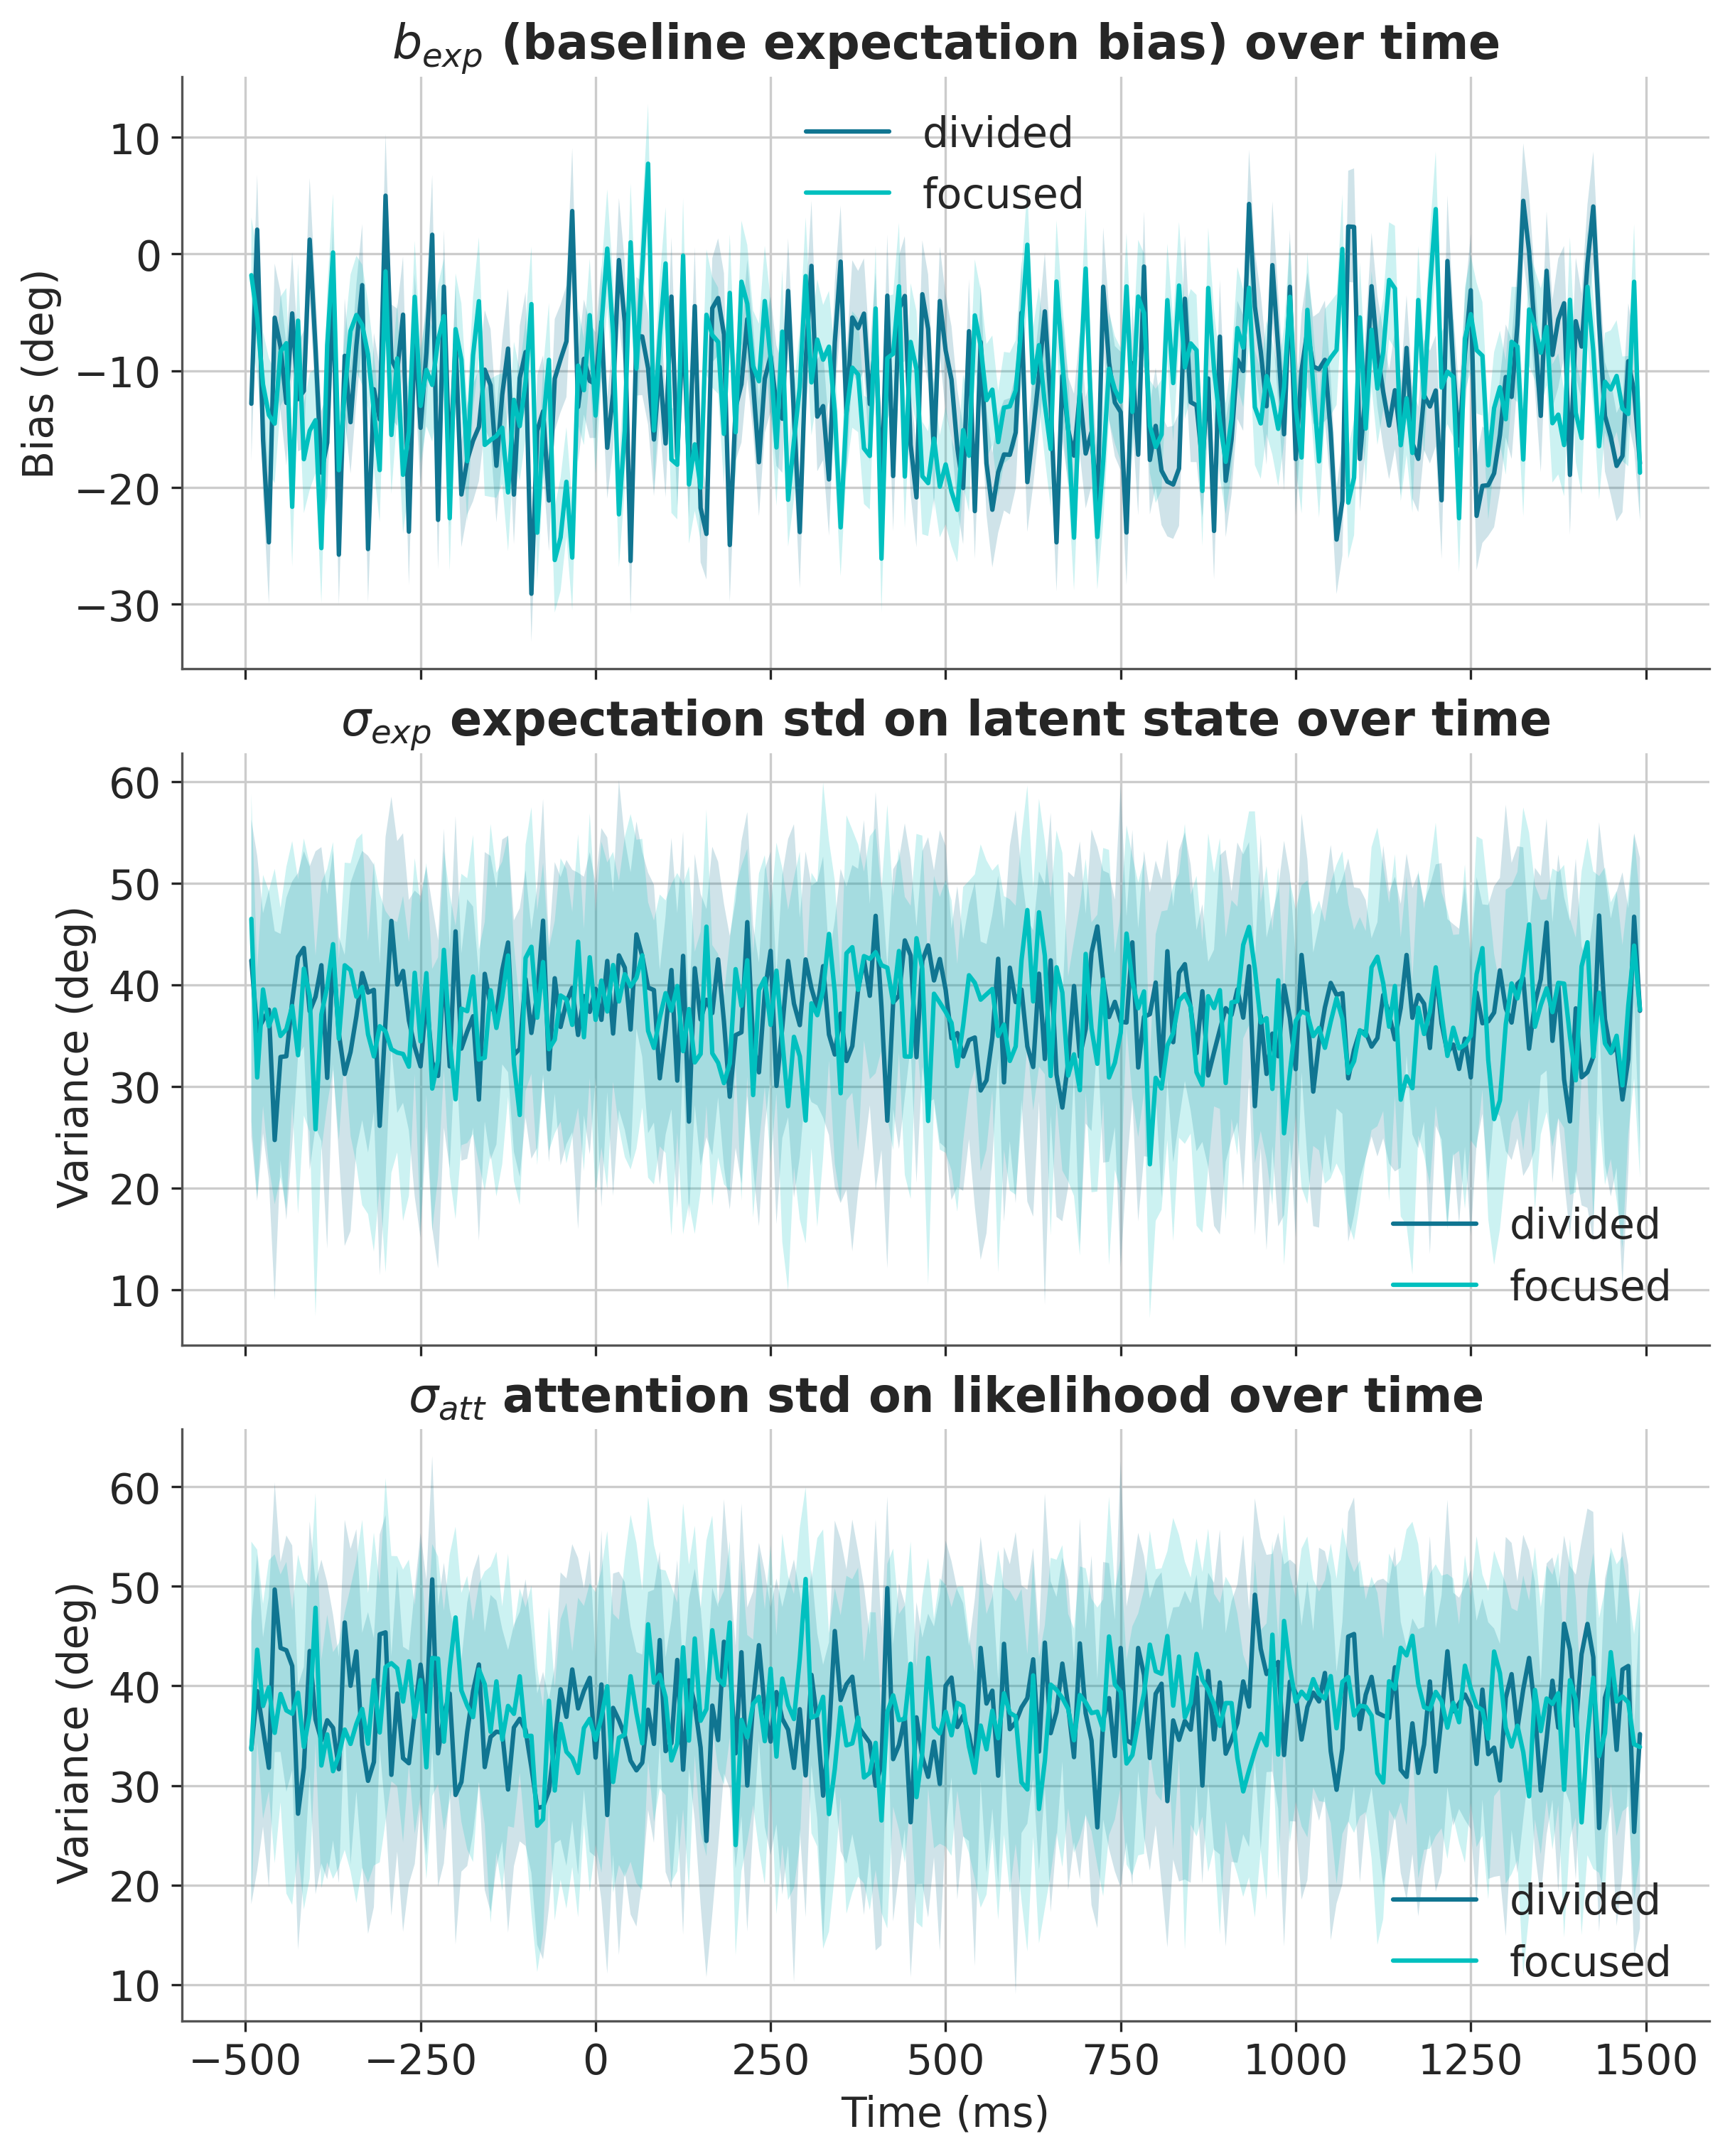

In [21]:
plot_params_over_time(a_bias, a_sig, b_sig, cats)